# Problem Description

I need to come up with a machine learning solution in order to segment groups of target customers who shop at the mall.

I will attempt this segmentation first with Hierarchical Clustering.  I will then compare my results with Hierarchical Clustering with K-Means Clustering.

Once these customers are segmented then a company can design effective advertising for these target groups.

The link for this data source is: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

# Exploratory Data Analysis

Below are the required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import scipy.cluster.hierarchy as hier

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## Check for missing data and errors

In [3]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
# Here I am looking at min, max and average values.
# I am also looking for error in our data like a very large annual income or very old age.
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


# Analysis (model building) using Hierarchical clustering

In [5]:
df2 = df
num_columns = df2.iloc[:, 2:5]
num_columns.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


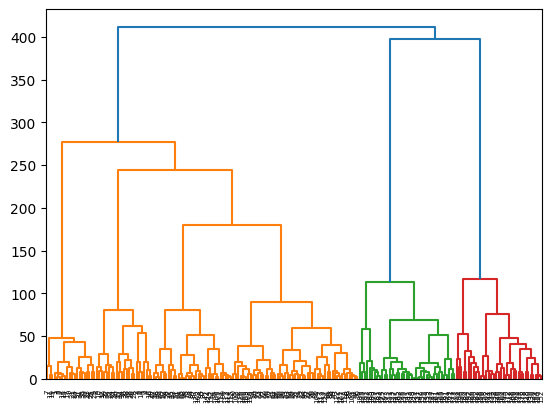

In [6]:
dendr = hier.dendrogram(hier.linkage(num_columns, method = 'ward'))
plt.show()

Let's choose 3 clusters to start based on the dendrogram above.

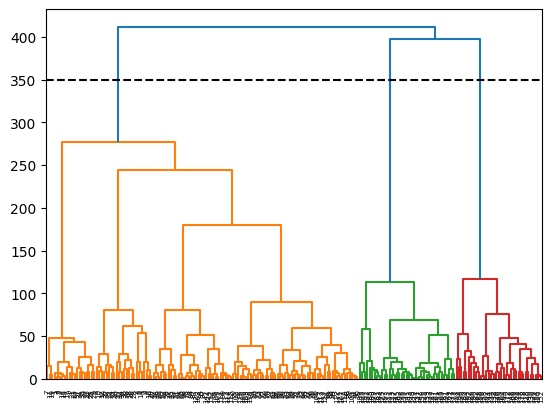

In [7]:
# I will draw a line showing what groups the 3 clusters represent.
dend = hier.dendrogram(hier.linkage(num_columns, method = 'ward'))
plt.axhline(y=350, color = 'black', linestyle = '--')
plt.show()

Using a scatterplot, let's see where the 3 clusters are and if they group our customers effectively.

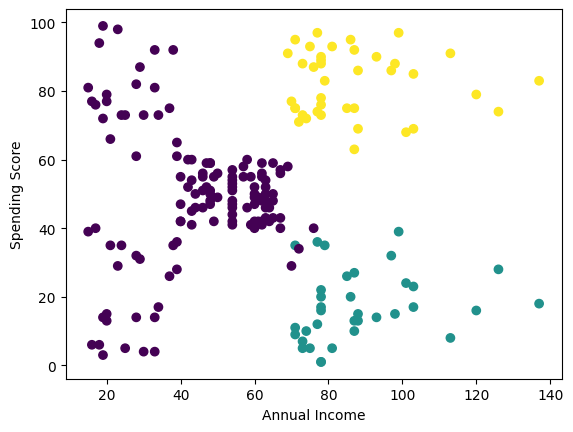

In [8]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
cluster.fit_predict(num_columns)

plt.scatter(num_columns['Annual Income (k$)'], num_columns['Spending Score (1-100)'], c = cluster.labels_)
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

Using 3 clusters, it seems we are missing 2 more.  Let's see what the chart looks like with 5 clusters.

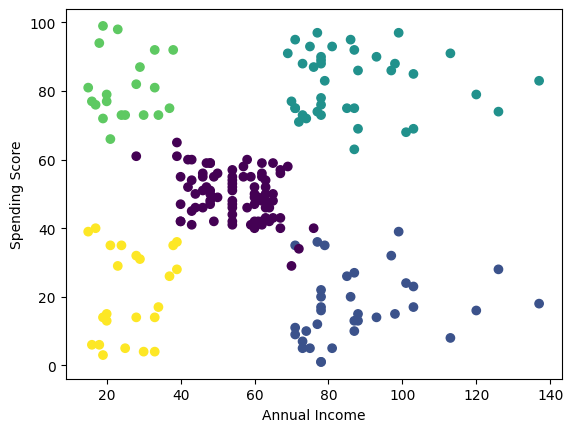

In [9]:
cluster = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
cluster.fit_predict(num_columns)

plt.scatter(num_columns['Annual Income (k$)'], num_columns['Spending Score (1-100)'], c = cluster.labels_)
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

This looks a lot better.  We can clearly see 5 clusters here.  So here we could recommend our marketing team to target the top 2 clusters above.

However, this analysis is not taking into account Gender and Age.  Let's use a different model to see if we can give more information to our marketing team.

## Data Cleaning

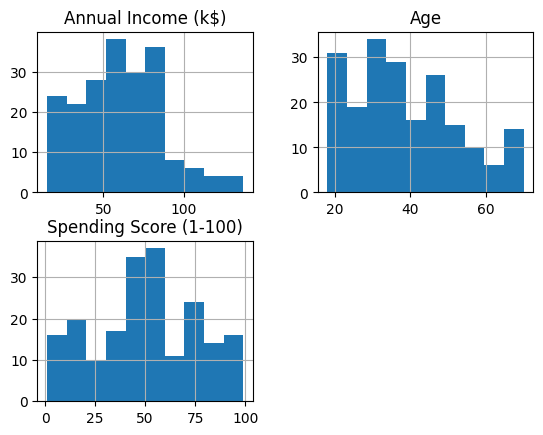

In [10]:
# With these histograms, I want to see if the values are normally distributed.
hist_data = df[['Annual Income (k$)', 'Age', 'Spending Score (1-100)']]
hist_data.hist()
plt.show()

In [11]:
# Since the histograms above show that the values are not normally distributed,
# then I will standardize by centering them around 0.
cl_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
target_cols = df[cl_names]
scaler = StandardScaler().fit(target_cols.values)
trform_cols = scaler.transform(target_cols.values)
scaled_cols = pd.DataFrame(trform_cols, columns = cl_names)
scaled_cols.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


## Convert Category column

In [12]:
# I purposely left out Gender because I need to create dummy variables for this column.
gender = df['Gender']
new_df = scaled_cols.join(gender)
new_df = pd.get_dummies(new_df, prefix = None, prefix_sep = '_', dummy_na = False, columns = None, sparse = False, drop_first = False, dtype =None)
new_df = new_df.drop(['Gender_Male'], axis = 1) # Only 1 column for gender is needed
new_df.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1


In [13]:
# Not seeing much correlation with the changed columns
new_df.corr()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
Annual Income (k$),1.000000,-0.012398,0.009903,-0.056410
Age,-0.012398,1.000000,-0.327227,-0.060867
Spending Score (1-100),0.009903,-0.327227,1.000000,0.058109
Gender_Female,-0.056410,-0.060867,0.058109,1.000000


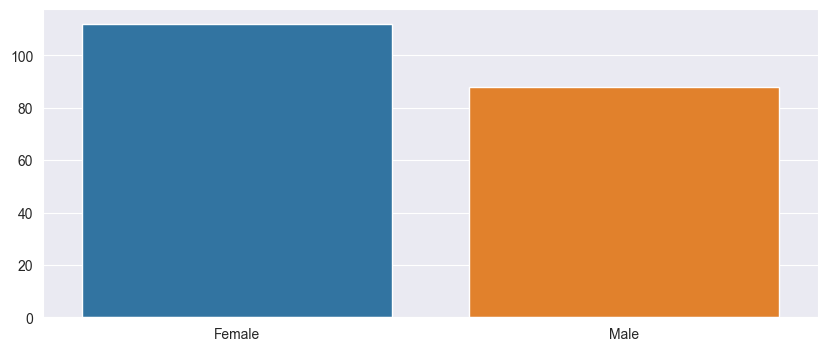

In [14]:
# In the gender analysis, I am seeing more female than male customers.
gender_vals = df.Gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=gender_vals.index, y = gender_vals.values)
plt.show()

# Analysis (model building) using K-means clustering

## 1st attempt

In order to create a K-Means model, I need to figure the right amount of clusters to use.  So I will use inertia values to help.  Inertia measures how well a dataset was clustered by K-Means.  It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.  A good model is one with a low inertia value and a small number of clusters.

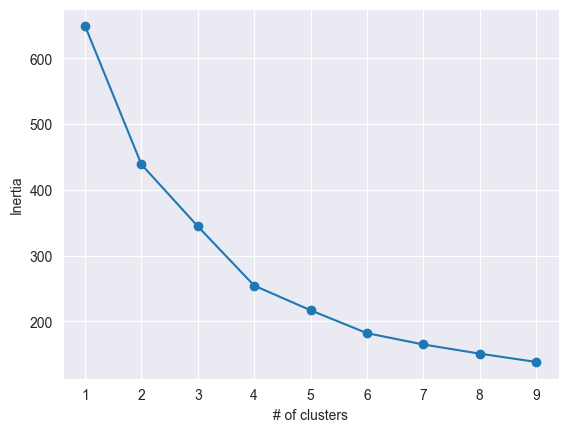

In [15]:
SSDS = [] # This list will have the sum of squared distance of samples.
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++')
    kmeans.fit(new_df)
    SSDS.append(kmeans.inertia_)# Inertia measures how well a dataset was clustered by K-Means
    
# I will put the results in a table and plot

dframe = pd.DataFrame({'Cluster':range(1,10), 'SSDS':SSDS})
cluster_number = dframe['Cluster'].to_numpy()
SSDS_vals = dframe['SSDS'].to_numpy()

plt.plot(cluster_number, SSDS_vals, marker = 'o')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

The optimal number of clusters is 4 because after 4 there is not much improvement with Inertia values.

Another clustering metric is silhouette score which ranges from - 1 to 1.  The higher the score, the better the model.
- 1: Means clusters are well apart from each other and clearly distinguished.
- 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
- -1: Means clusters are assigned in the wrong way.

In [16]:
# I will now build a K-Means model using 4 clusters
kmeans = KMeans(n_clusters= 4, init = 'k-means++')
kmeans.fit(new_df)

# Now I will print the value of the silhouette score for this model.
print(silhouette_score(new_df, kmeans.labels_, metric = 'euclidean'))

0.35027020434653977


In [17]:
# The value of approximately 0.35 for the silhouette score is not a bad start.  Let's see what our 4 clusers look like.

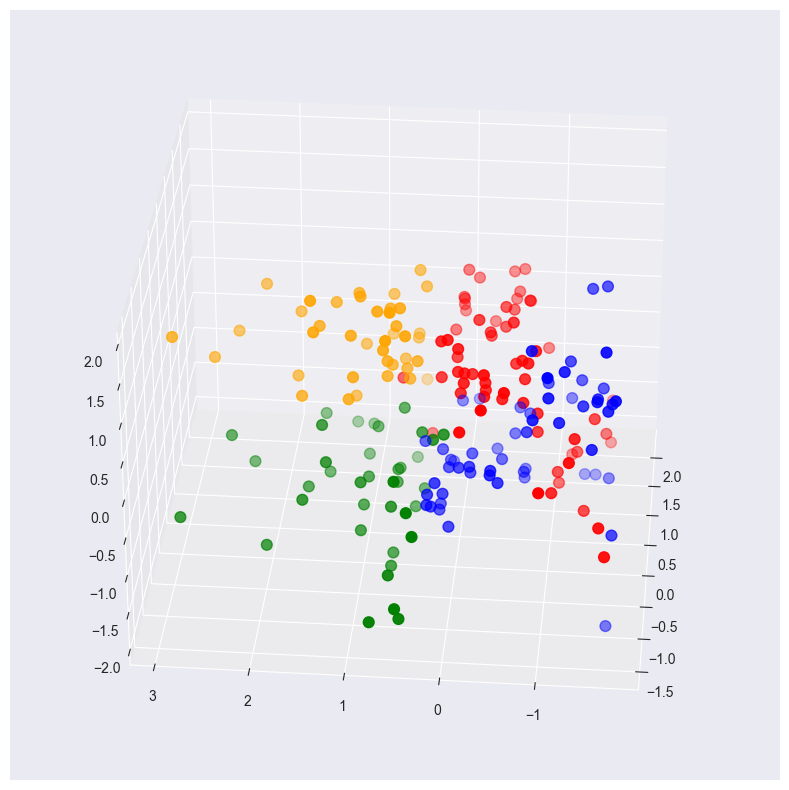

In [18]:
clusters = kmeans.fit_predict(new_df)
new_df["label"] = clusters

fig = plt.figure(figsize = (21,10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(new_df.Age[new_df.label == 0], new_df["Annual Income (k$)"][new_df.label == 0], new_df["Spending Score (1-100)"][new_df.label == 0], c='blue', s=60)
ax.scatter(new_df.Age[new_df.label == 1], new_df["Annual Income (k$)"][new_df.label == 1], new_df["Spending Score (1-100)"][new_df.label == 1], c='red', s=60)
ax.scatter(new_df.Age[new_df.label == 2], new_df["Annual Income (k$)"][new_df.label == 2], new_df["Spending Score (1-100)"][new_df.label == 2], c='green', s=60)
ax.scatter(new_df.Age[new_df.label == 3], new_df["Annual Income (k$)"][new_df.label == 3], new_df["Spending Score (1-100)"][new_df.label == 3], c='orange', s=60)

ax.view_init(30,185)
plt.show()


The clusters illustration above shows that there is some overlap with red and blue.

## 2nd attempt to build a better model

To improve our model, I will use a feature selection technique called Principal Component Analysis.  PCA helps me reduce the dimensions in the dataset.  It also helps identify the main axes of variance within a data set.

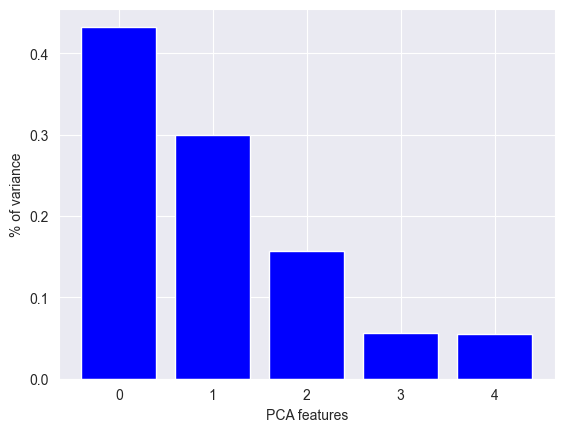

In [19]:
pca = PCA(n_components = 5)
princ_comp = pca.fit_transform(new_df)

feat = range(pca.n_components_)
plt.bar(feat, pca.explained_variance_ratio_, color = 'blue')
plt.xlabel('PCA features')
plt.ylabel('% of variance')
plt.xticks(feat)
plt.show()

The chart above shows that the 1st 2 components explain 70% of the dataset variance.

In [20]:
# I am creating a dataframe for the PCA components before putting it in our model.
PCA_components = pd.DataFrame(princ_comp)
PCA_components

,0,1,2,3,4
0,-2.207597,-0.795763,0.906193,0.350018,0.899316
1,-2.017321,-1.833376,-0.290074,0.004874,0.772327
2,-2.345859,0.112031,1.723436,1.035021,0.082289
3,-2.025320,-1.661499,-0.280448,0.456022,-0.129305
4,-2.139275,-0.247061,0.313337,0.622546,-0.109401
...,...,...,...,...,...
195,2.855597,-0.855803,-0.115147,-0.357330,-0.716007
196,2.065131,1.014524,0.913741,-0.810484,-1.033152
197,2.996093,-0.824669,0.235109,-0.890659,0.125808
198,2.279262,0.677294,1.931599,-1.304759,-0.162804


I will now build the model again using just hte 1st 2 principal components.  Then I will decide how many clusters to use.

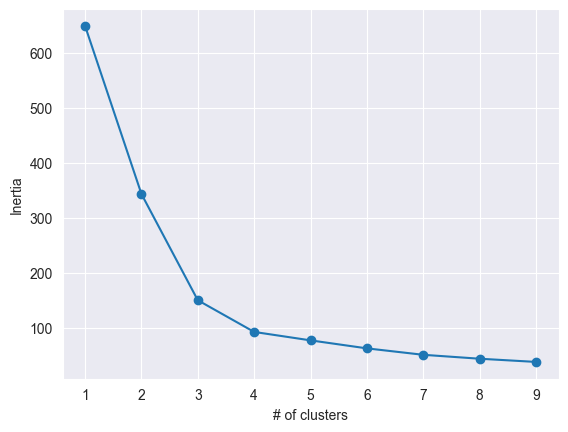

In [21]:
SSDS = []
cluster_number = range(1,10)

for cluster in cluster_number:
    kmeans = KMeans(n_clusters = cluster)
    kmeans.fit(PCA_components.iloc[:,:2])
    SSDS.append(kmeans.inertia_)
    
plt.plot(cluster_number, SSDS, marker = 'o')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()

Looks like the best number of clusters is still 4

In [22]:
# I will again use 4 for our number of clusters but now use the 1st 2 principal components.
kmeans2 = KMeans(n_clusters = 4)
kmeans2.fit(PCA_components.iloc[:,:2])

# Now I will print the value of the silhouette score for this enhanced model.
print(silhouette_score(PCA_components.iloc[:,:2], kmeans2.labels_, metric = 'euclidean'))

0.5567483257114489


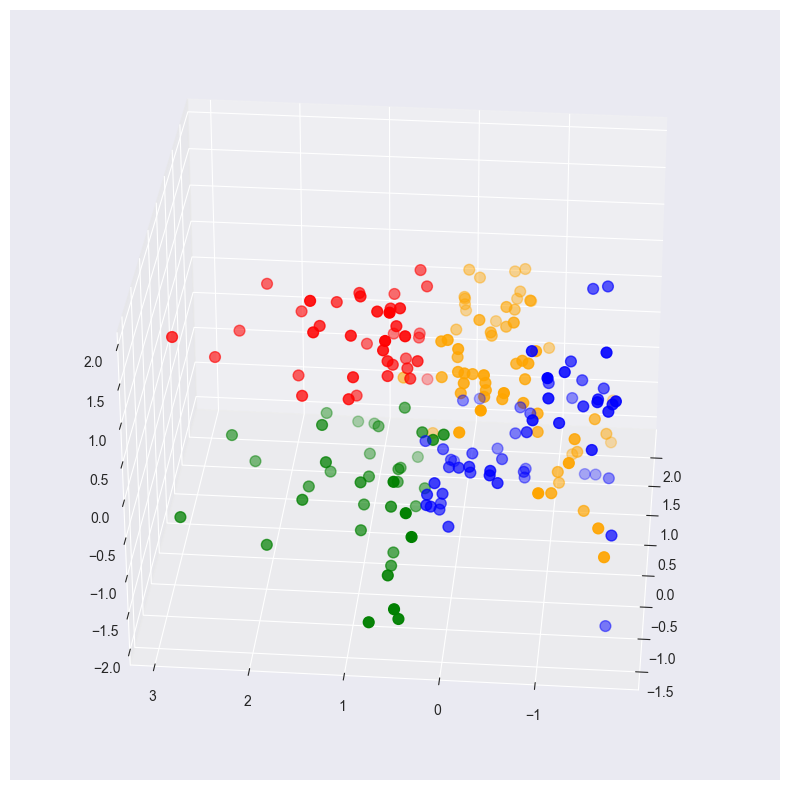

In [23]:
kmeans2 = KMeans(n_clusters=4)

clusters = kmeans2.fit_predict(PCA_components.iloc[:,:2])
new_df["label"] = clusters

fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(new_df.Age[new_df.label == 0], new_df["Annual Income (k$)"][new_df.label == 0], new_df["Spending Score (1-100)"][new_df.label == 0], c='blue', s=60)
ax.scatter(new_df.Age[new_df.label == 1], new_df["Annual Income (k$)"][new_df.label == 1], new_df["Spending Score (1-100)"][new_df.label == 1], c='red', s=60)
ax.scatter(new_df.Age[new_df.label == 2], new_df["Annual Income (k$)"][new_df.label == 2], new_df["Spending Score (1-100)"][new_df.label == 2], c='green', s=60)
ax.scatter(new_df.Age[new_df.label == 3], new_df["Annual Income (k$)"][new_df.label == 3], new_df["Spending Score (1-100)"][new_df.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

There is a little less overlap with the far right clusters now but the silhouette score did improve substantially from 0.35 to 0.61

## Segmentation Analysis

In [24]:
# Create dataframe
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis = 1)

In [25]:
# Add clusters to dataframe
predctn = kmeans2.fit_predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = predctn
frame

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,1
3,Female,23,16,77,1
4,Female,31,17,40,1
...,...,...,...,...,...
195,Female,35,120,79,2
196,Female,45,126,28,0
197,Male,32,126,74,2
198,Male,32,137,18,0


Let's learn about the attributes about each cluster

In [26]:
avgs = df.groupby(['cluster'], as_index = False).mean()
avgs # Creating a table to get the averages

/var/folders/34/c24kz45d5dsf0ql7s3zbqr240000gn/T/ipykernel_1520/620306859.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgs = df.groupby(['cluster'], as_index = False).mean()


,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,39.368421,86.500000,19.578947
1,1,25.438596,40.000000,60.298246
2,2,32.875000,86.100000,81.525000
3,3,53.984615,47.707692,39.969231


I will now use bar charts to visualize the results in the data frame above.

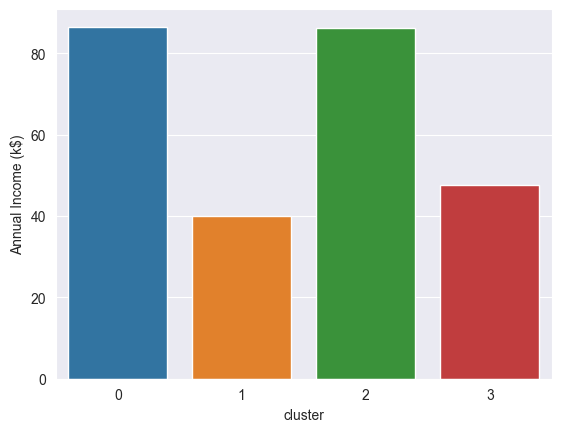

In [27]:
sns.barplot(x='cluster', y = 'Annual Income (k$)', data = avgs)
plt.show()

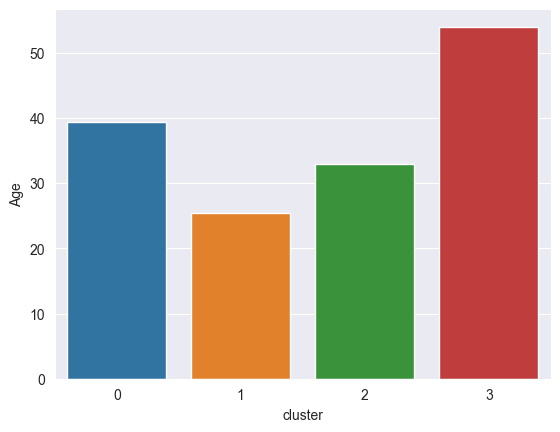

In [28]:
sns.barplot(x='cluster', y = 'Age', data = avgs)
plt.show()

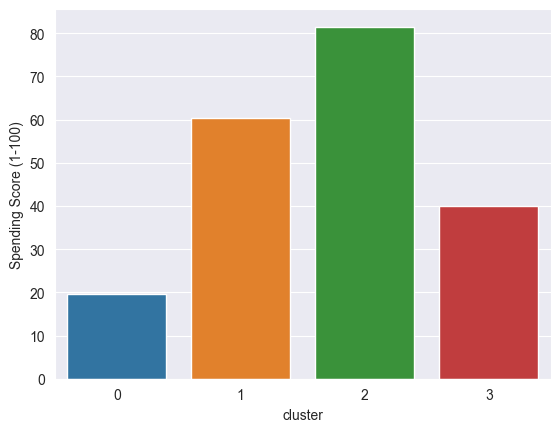

In [29]:
sns.barplot(x='cluster', y = 'Spending Score (1-100)', data = avgs)
plt.show()

Gender Breakdown

In [30]:
gender_df = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
gender_df

Gender
cluster Gender        
0       Female      19
        Male        19
1       Female      34
        Male        23
2       Female      22
        Male        18
3       Female      37
        Male        28

# Discussion / Conclusion

Unlike with the Hierarchical clustering where I am only looking at Income and Spending Score, I use Income, Spending Score, Age and Gender in my K-Means clustering model.

In my K-Means clustering model, after getting the optimal number of clusters and performing principal analysis, I looked at the attributes for each cluster.  This is what I found for these 4 types of customers:

Cluster 0:
- High income
- Average age of 40
- same number of male and female customers
- Low spending score

Cluster 1:
- Low income
- Average age of 25
- Mostly female
- High spending score

Cluster 2:
- High income
- Average age of 30
- Mostly female
- High spending score

Cluster 3:
- Low income
- Average age of 50
- Mostly female
- Low to mid spending score

Based on the attributes for the 4 clusters above, I would recommend targeting advertising for clusters 1 and 2 based on their high spending scores.  Cluster 1 looks like they are spenders that are not as interested in saving and are probably spending above their means.  Cluster 2 are high income spenders who may not be just buying for themselves but for their families as well based on seeing the average age of 30 and most of the shoppers are female.